In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import deque
import random
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

from quant_invest_lab.data_provider import download_crypto_historical_data

2023-02-27 16:56:12.807397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 16:56:13.503540: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 16:56:13.503562: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 16:56:15.411815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
symbol= 'BTC-USDT'

df_BTC = download_crypto_historical_data(symbol,'1hour')
df_BTC["Return"] = df_BTC.Close.pct_change()
df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(45208, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Return
Date,,,,,,,,
2018-01-01 01:00:00,1.514765e+09,12933.000001,13173.464605,13499.999990,12510.000000,1.631550,21330.491751,0.018593
2018-01-01 02:00:00,1.514768e+09,13173.464605,13400.899973,13400.899973,12510.000008,1.243886,16278.918914,0.017265
2018-01-01 03:00:00,1.514772e+09,13498.999989,13889.000000,13889.000000,12757.698405,0.823831,11011.354902,0.036423
2018-01-01 04:00:00,1.514776e+09,13799.000000,13000.000000,13799.000000,13000.000000,1.835235,24085.661987,-0.064007
2018-01-01 05:00:00,1.514779e+09,13000.000000,12717.136730,13242.775254,12600.000001,1.883597,24416.806644,-0.021759


In [3]:
df= df_BTC.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

2023-02-27 16:56:24.452863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 16:56:24.456304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 16:56:24.456651: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 16:56:24.456725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-154PLAM): /proc/driver/nvidia/version does not exist
/tmp/ipykernel_44150/3317277231.py:22: UserWarning: `tf.layers.dense

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

# GYM environnement

In [7]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

custom_env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 300),
               unit_side = 'right')

/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'nu

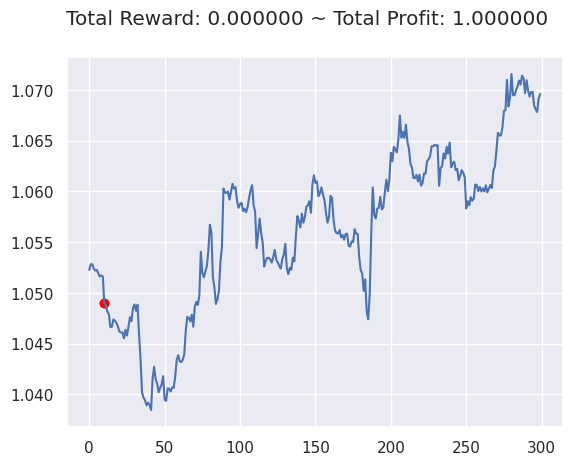

In [10]:
custom_env.reset()
custom_env.render()

In [11]:

print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", custom_env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())

custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1229001800089833


In [20]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape=(custom_env.observation_space.shape[0],custom_env.observation_space.shape[1])))
model.add(tf.keras.layers.Dense(custom_env.action_space.n, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [22]:
for epoch in range(50):
    state = custom_env.reset()
    while True:
        action = model.predict(state)
        next_state, reward, done, _ = custom_env.step(action)
        model.fit(state, reward, epochs=1, verbose=0)
        state = next_state
        if done:
            break
        
# Build the trading strategy
state = custom_env.reset()
while True:
    action = model.predict(state)
    state, reward, done, _ = custom_env.step(action)
    if done:
        break

1


ValueError: Error when checking input: expected dense_5_input to have 3 dimensions, but got array with shape (10, 2)

/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


info: {'total_reward': 127.89999999998972, 'total_profit': 0.9960191916619187, 'position': 1}


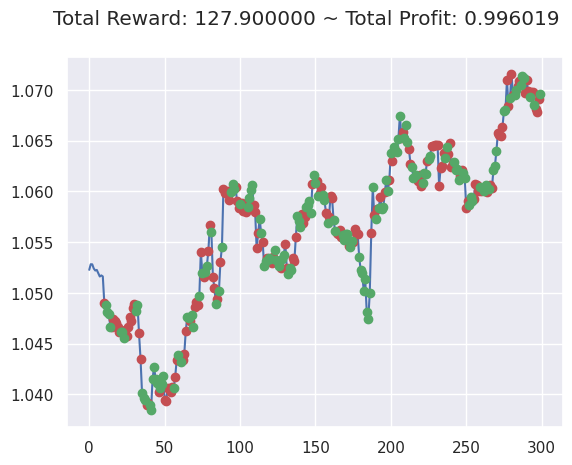

In [12]:
observation = custom_env.reset()
while True:
    action = custom_env.action_space.sample()
    observation, reward, done, info = custom_env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
custom_env.render_all()
plt.show()

In [ ]:
# Train the model
for epoch in range(50):
    state = env.reset()
    while True:
        action = model.predict(state)
        next_state, reward, done, _ = env.step(action)
        model.fit(state, reward, epochs=1, verbose=0)
        state = next_state
        if done:
            break
        
# Build the trading strategy
state = env.reset()
while True:
    action = model.predict(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

In [ ]:
import pandas as pd

# Download the data
data = pd.read_csv('https://finance.yahoo.com/quote/AAPL/history?p=AAPL')

# Select the relevant columns
data = data[['Date', 'Close']]

# Convert the date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the date column as the index
data.set_index('Date', inplace=True)

# Plot the data
data.plot(figsize=(10, 6))

In [ ]:
# Generate the trading signals
signals = []
for i in range(len(data)):
    state = data.iloc[i].values
    action = model.predict(state)
    signals.append(action)

# Convert the signals to a Pandas series
signals = pd.Series(signals, index=data.index)

In [ ]:
import matplotlib.pyplot as plt

# Plot the price chart
plt.figure(figsize=(10, 6))
plt.plot(data)

# Plot the trading signals
plt.scatter(signals.index, data[signals == 1], color='green', marker='^')
plt.scatter(signals.index, data[signals == 2], color='red', marker='v')

In [ ]:
import pandas as pd

# Download the data
data = pd.read_json('https://finance.yahoo.com/quote/AAPL/')

# Select the relevant columns
data = data[['regularMarketPrice']]

# Convert the data to a NumPy array
data = data.values

In [ ]:
signal = model.predict(data)